Name : Juveriya Rahman 
Github Link : 

In [2]:
#Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


# Step 2: Load Data
df = pd.read_csv("online_retail.csv")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Step 3: Preprocessing
df = df[df['CustomerID'].notnull()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [4]:
#Step 4: RFM Analysis
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [5]:
#Step 5: Normalization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


c:\Users\cryst\OneDrive\Desktop\shopper_spectrum_template\newenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cryst\OneDrive\Desktop\shopper_spectrum_template\newenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cryst\OneDrive\Desktop\shopper_spectrum_template\newenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cryst\OneDrive\Desktop\shopper_spectrum_templa

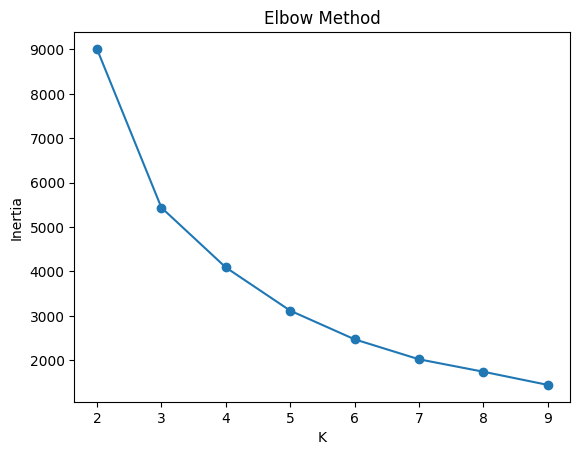

In [6]:
#Step 6: Elbow Method
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()


In [7]:
# Step 7: Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Optional: Label segments
def segment_label(row):
    if row['Recency'] < rfm['Recency'].median() and row['Frequency'] > rfm['Frequency'].median() and row['Monetary'] > rfm['Monetary'].median():
        return 'High-Value'
    elif row['Frequency'] > rfm['Frequency'].median():
        return 'Regular'
    elif row['Recency'] > rfm['Recency'].median():
        return 'At-Risk'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(segment_label, axis=1)


c:\Users\cryst\OneDrive\Desktop\shopper_spectrum_template\newenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
# Step 8: Product Recommendation - Item-Item Collaborative Filtering
product_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
product_similarity = cosine_similarity(product_matrix.T)
product_similarity_df = pd.DataFrame(product_similarity, index=product_matrix.columns, columns=product_matrix.columns)

# Function to recommend products
def recommend_products(product_code, top_n=5):
    if product_code in product_similarity_df:
        sim_scores = product_similarity_df[product_code].sort_values(ascending=False)
        return sim_scores.iloc[1:top_n+1].index.tolist()
    else:
        return []

# Example usage
recommend_products('85123A')


['21175', '47556B', '21108', '48185', '21733']

In [9]:
import joblib
joblib.dump(kmeans, 'rfm_kmeans_model.pkl')
joblib.dump(scaler, 'rfm_scaler.pkl')
product_similarity_df.to_pickle("product_similarity.pkl")


C:\Users\cryst\AppData\Local\Temp\ipykernel_22740\1104597625.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")


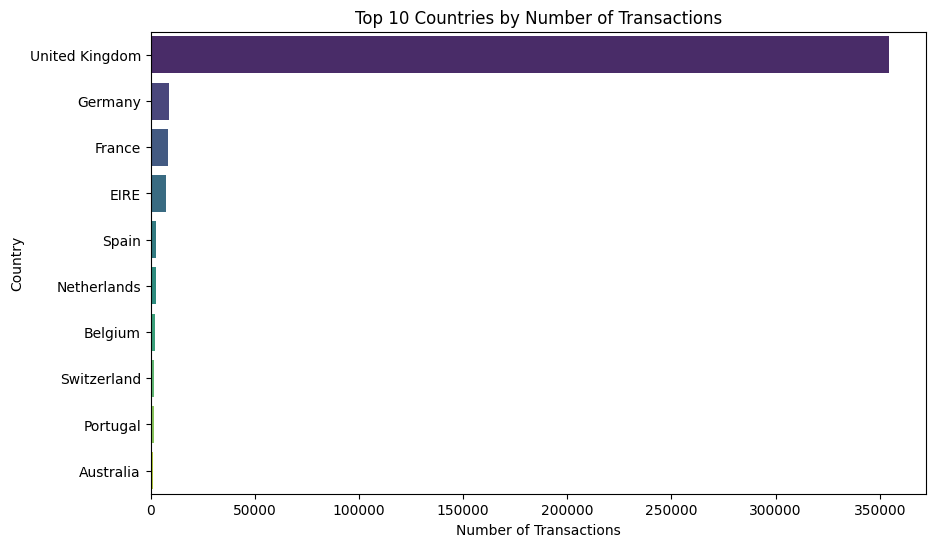

In [10]:
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.show()

C:\Users\cryst\AppData\Local\Temp\ipykernel_22740\1329093455.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="magma")


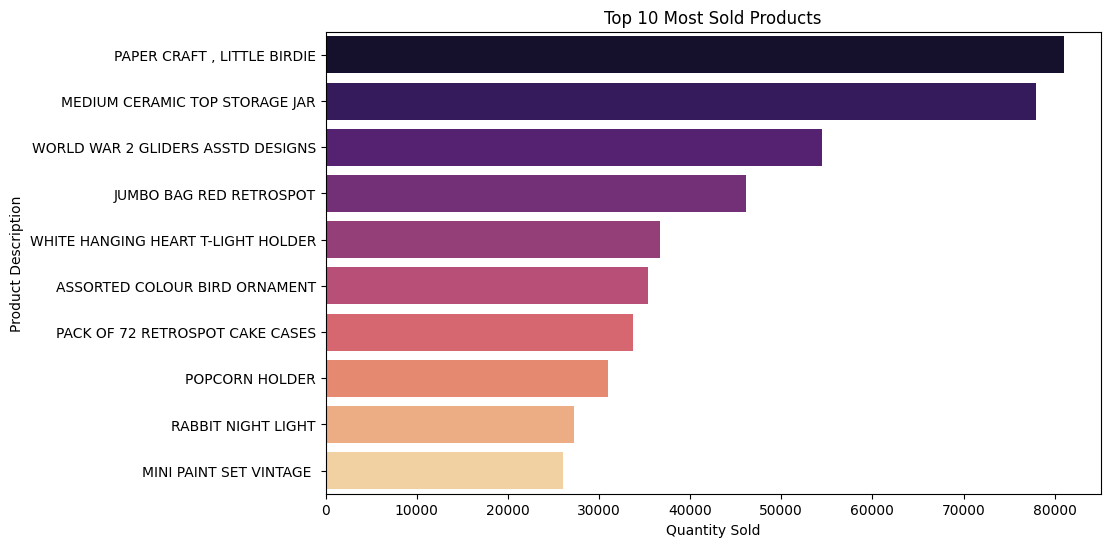

In [11]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="magma")
plt.title("Top 10 Most Sold Products")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.show()

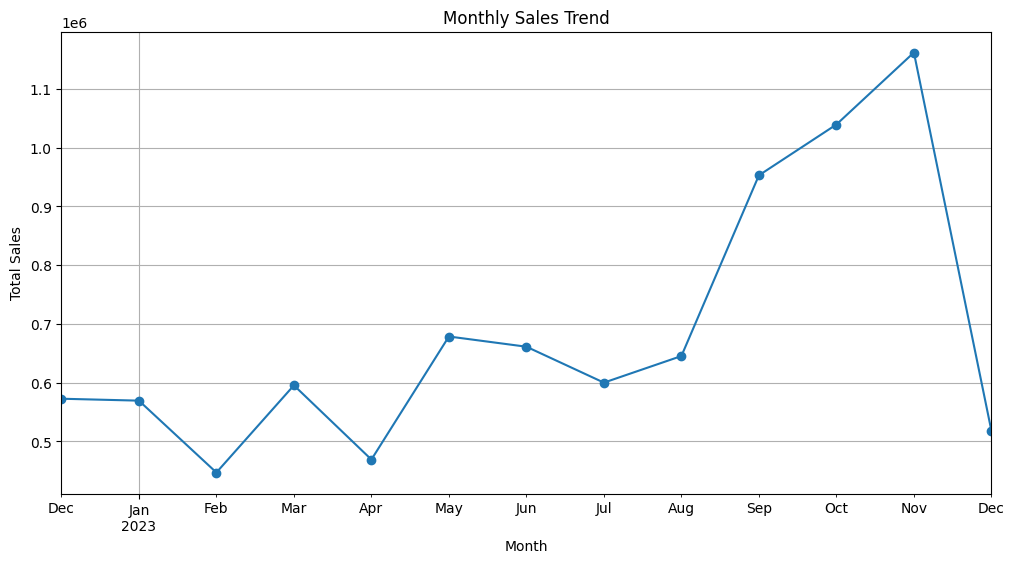

In [12]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalAmount'].sum()
monthly_sales.plot(kind='line', figsize=(12,6), marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

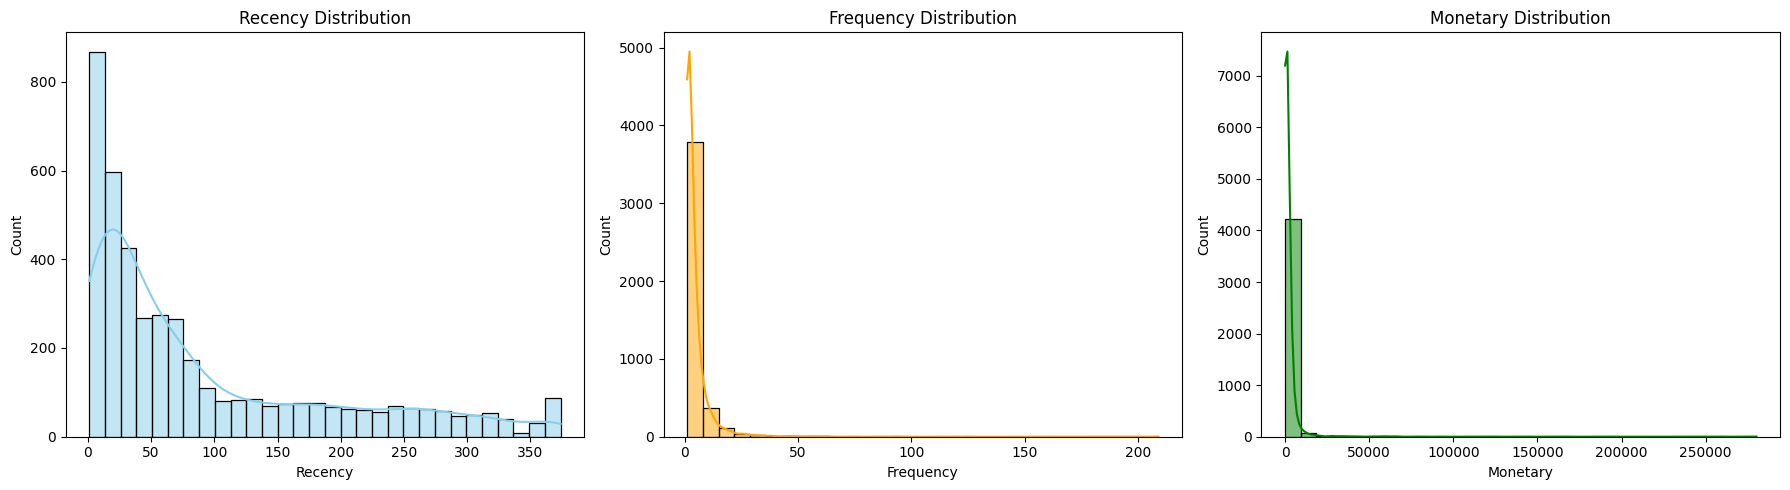

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], ax=axes[0], bins=30, color='skyblue', kde=True)
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], ax=axes[1], bins=30, color='orange', kde=True)
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], ax=axes[2], bins=30, color='green', kde=True)
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()